# 📘 Modelo de Regresión Logística Multinomial personalizado sobre el dataset de crédito


In [1]:
# 📦 Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle


In [2]:
# 📂 Cargar el dataset
data = pd.read_csv('UCI_Credit_Card.csv')


In [3]:
# 🔍 Exploración inicial del dataset
print(data.head())
print(data.info())
print(data.describe())


   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default.payment.next.month  
0       0.0       0.0   

In [4]:
# ✅ Verificar valores nulos y eliminar duplicados
print(data.isnull().sum())
data = data.drop_duplicates()


ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


In [5]:
# 🎯 Separar características (X) y la variable objetivo (y)
X = data.drop('default.payment.next.month', axis=1)
y = data['default.payment.next.month']


In [6]:
# 🔄 Codificar variables categóricas si las hay
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    X = pd.get_dummies(X, columns=categorical_cols)


In [7]:
# 📊 División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# ⚖️ Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
# ➕ Añadir término de intercepción (bias)
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])


In [10]:
# 🧠 Implementación personalizada de regresión logística binaria
class LogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.loss_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, X, y, weights):
        m = X.shape[0]
        h = self.sigmoid(X @ weights)
        loss = (-1/m) * np.sum(y * np.log(h) + (1-y) * np.log(1-h))
        return loss

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)

        for i in range(self.max_iter):
            h = self.sigmoid(X @ self.weights)
            gradient = (1/m) * (X.T @ (h - y))
            new_weights = self.weights - self.learning_rate * gradient
            loss = self.compute_loss(X, y, new_weights)
            self.loss_history.append(loss)

            if np.linalg.norm(new_weights - self.weights) < self.tol:
                print(f"Convergencia alcanzada en la iteración {i+1}")
                break

            self.weights = new_weights
        return self

    def predict_proba(self, X):
        return self.sigmoid(X @ self.weights)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [11]:
# 🔄 Implementación de Regresión Logística Multiclase (One-vs-Rest)
class MultiClassLogisticRegression:
    def __init__(self, learning_rate=0.01, max_iter=1000, tol=1e-4):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.classifiers = []

    def fit(self, X, y):
        self.classes = np.unique(y)

        for cls in self.classes:
            y_binary = (y == cls).astype(int)
            lr = LogisticRegression(learning_rate=self.learning_rate, max_iter=self.max_iter, tol=self.tol)
            lr.fit(X, y_binary)
            self.classifiers.append(lr)
        return self

    def predict_proba(self, X):
        probas = np.array([clf.predict_proba(X) for clf in self.classifiers]).T
        return probas / probas.sum(axis=1, keepdims=True)

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes[np.argmax(probas, axis=1)]


In [12]:
# 🏋️ Entrenamiento del modelo
model = MultiClassLogisticRegression(learning_rate=0.1, max_iter=1000)
model.fit(X_train, y_train)


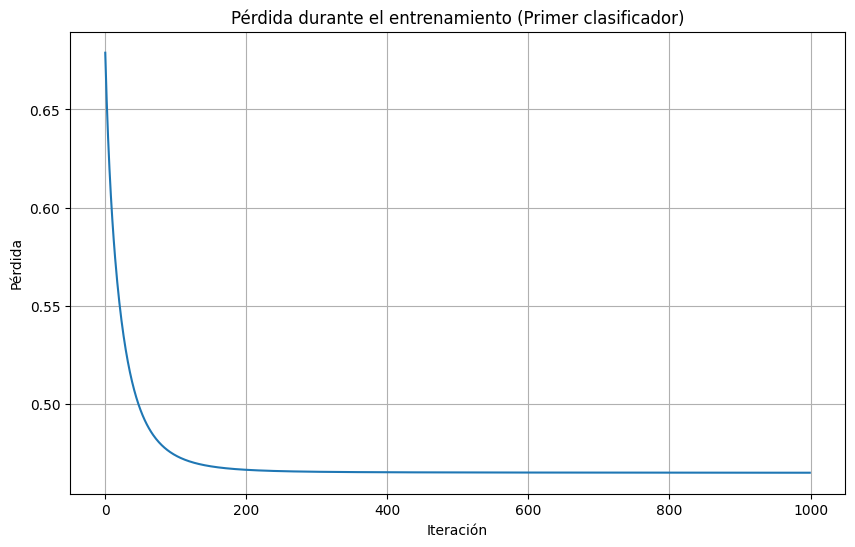

In [13]:
# 📈 Visualizar la pérdida del primer clasificador
plt.figure(figsize=(10, 6))
plt.plot(model.classifiers[0].loss_history)
plt.title('Pérdida durante el entrenamiento (Primer clasificador)')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.grid()
plt.show()


In [14]:
# 📊 Evaluación del modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión: {accuracy:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión: 0.8105
Matriz de confusión:
[[4554  133]
 [1004  309]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4687
           1       0.70      0.24      0.35      1313

    accuracy                           0.81      6000
   macro avg       0.76      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000



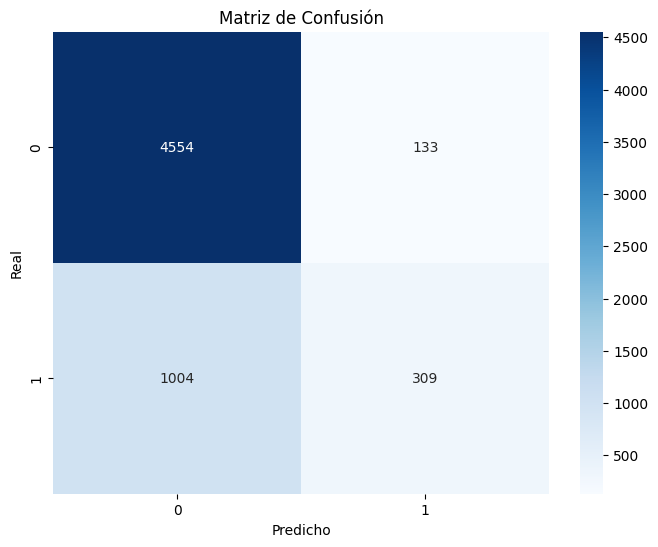

In [15]:
# 🔍 Matriz de confusión visual
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes, yticklabels=model.classes)
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()


In [16]:
# 📉 Mostrar los coeficientes más importantes
feature_names = ['Intercept'] + list(data.drop('default.payment.next.month', axis=1).columns)
for i, cls in enumerate(model.classes):
    print(f"\nCoeficientes para la clase {cls}:")
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.classifiers[i].weights
    })
    coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)
    print(coef_df.head(10))



Coeficientes para la clase 0:
      Feature  Coefficient
0   Intercept     1.454506
7       PAY_0    -0.650824
20   PAY_AMT2     0.197523
13  BILL_AMT1     0.167323
19   PAY_AMT1     0.134727
2   LIMIT_BAL     0.111295
8       PAY_2    -0.106263
9       PAY_3    -0.083875
5    MARRIAGE     0.079104
4   EDUCATION     0.078284

Coeficientes para la clase 1:
      Feature  Coefficient
0   Intercept    -1.454506
7       PAY_0     0.650824
20   PAY_AMT2    -0.197523
13  BILL_AMT1    -0.167323
19   PAY_AMT1    -0.134727
2   LIMIT_BAL    -0.111295
8       PAY_2     0.106263
9       PAY_3     0.083875
5    MARRIAGE    -0.079104
4   EDUCATION    -0.078284


In [17]:
# 💾 Guardar el modelo y el scaler
with open('credit_card_default_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
